In [ ]:
# Inspect GPU
!nvidia-smi

Tue May 11 17:42:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
load_location =  "./drive/MyDrive/11785/hw4p2/"
save_location =  "./drive/MyDrive/11785/project/transfer_learning/"

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle competitions download -c 11785-spring2021-hw4p2

In [ ]:
# !unzip dev.npy.zip
# !unzip test.npy.zip
# !unzip train.npy.zip
# !unzip train_transcripts.npy.zip
# !unzip dev_transcripts.npy.zip

In [ ]:
!pip install python-Levenshtein

In [ ]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from torch.utils import data
import Levenshtein

cuda = torch.cuda.is_available()
print(cuda, sys.version)
# device = torch.device("cuda" if cuda else "cpu")
device = torch.device("cuda" if cuda else "cpu")
np.random.seed(5111785)
torch.manual_seed(5111785)

LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
         'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ', '<eos>']

True 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [ ]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    '''
    letter2index = {letter:index for index, letter in enumerate(letter_list)}
    index2letter = {index:letter for index, letter in enumerate(letter_list)}
    return letter2index, index2letter
    
def transform_letter_to_index(raw_transcripts):
    '''
    Transforms text input to numerical input by converting each letter 
    to its corresponding index from letter_list

    Args:
        raw_transcripts: Raw text transcripts with the shape of (N, )
    
    Return:
        transcripts: Converted index-format transcripts. This would be a list with a length of N
    '''  
    index_transcript = []
    for sentence in raw_transcripts:
      try:
        sentence = " ".join([word.decode("utf-8") for word in sentence])
      except:
        sentence = " ".join([word for word in sentence])
      index_transcript.append([letter2index[LETTER_LIST[0]]]+[letter2index[letter] for letter in sentence]+[letter2index[LETTER_LIST[-1]]])
    return index_transcript

def transform_index_to_letter(index_transcript):
    letter_transcript = []
    for idx in index_transcript:
      letter_transcript.append(
          ''.join(
              [LETTER_LIST[int(idx[i])] for i in range(len(idx))]
              )
          )
    
    return letter_transcript
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
# # Load the training, validation and testing data
# train_data = np.load('train.npy', allow_pickle=True, encoding='bytes')
# valid_data = np.load('dev.npy', allow_pickle=True, encoding='bytes')
# # test_data = np.load('test.npy', allow_pickle=True, encoding='bytes')

# # Load the training, validation raw text transcripts
# raw_train_transcript = np.load('train_transcripts.npy', allow_pickle=True,encoding='bytes')
# raw_valid_transcript = np.load('dev_transcripts.npy', allow_pickle=True,encoding='bytes')

# # TODO: Convert the raw text transcripts into indexes
# train_transcript = transform_letter_to_index(raw_train_transcript)
# valid_transcript = transform_letter_to_index(raw_valid_transcript)

In [ ]:
# raw_train_transcript

In [ ]:
# raw_train_transcript

In [ ]:
# class MyDataset(data.Dataset):
#     def __init__(self, X, Y=None):
#         self.X = X
#         self.Y = Y

#     def __len__(self):
#         return self.X.shape[0]

#     def __getitem__(self, index):
#         # For testing set, return only x
#         if self.Y == None:
#             return torch.tensor(self.X[index].astype(np.float32))
#         # For training and validation set, return x and y
#         else:
#             return torch.tensor(self.X[index].astype(np.float32)), torch.tensor(self.Y[index])

In [ ]:
def collate_train_val(data):
    """
    Return:
        pad_x: the padded x (training/validation speech data) 
        pad_y: the padded y (text labels - transcripts)
        x_len: the length of x
        y_len: the length of y
    """
    Xs, ys, x_lengths, y_lengths = [], [], [], []

    for x,y in data:
        Xs.append(x)
        ys.append(y)
        x_lengths.append(x.shape[0])
        y_lengths.append(len(y))
    return (rnn_utils.pad_sequence(Xs, batch_first=False), x_lengths), (rnn_utils.pad_sequence(ys, batch_first=True), y_lengths)

def collate_test(data):
    """
    Return:
        pad_x: the padded x (testing speech data) 
        x_len: the length of x
    """
    Xs, x_lengths = [], []

    for x in data:
      Xs.append(x)
      x_lengths.append(x.shape[0])

    return (rnn_utils.pad_sequence(Xs, batch_first=False), x_lengths)

In [ ]:
BATCH_SIZE = 64

In [ ]:
# # Create datasets
# train_dataset = MyDataset(train_data, train_transcript)
# valid_dataset = MyDataset(valid_data, valid_transcript)
# # test_dataset = MyDataset(test_data)

# # Create data loaders
# train_loader = data.DataLoader(train_dataset, batch_size
#                                =BATCH_SIZE, shuffle=True, 
#                                num_workers=4, pin_memory=True, collate_fn=collate_train_val)
# valid_loader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
#                                num_workers=4, pin_memory=True, collate_fn=collate_train_val)

In [ ]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)

    def forward(self, x, lens):
      x, hidden_state = self.blstm(x)
      #print("input >>>>>",x.shape)
      x, output_lens = rnn_utils.pad_packed_sequence(x, batch_first=True)
      #print("shape:", x.shape)
      if x.shape[1] % 2 != 0:
        x = x[:,:-1,:]
        #print("shape:", x.shape)
      x = x.reshape(x.shape[0], x.shape[1]//2, x.shape[2]*2)
      #print("after reshape:", x.shape)
      out = rnn_utils.pack_padded_sequence(x, output_lens//2, enforce_sorted=False, batch_first=True) # repack for next layer
      # print("out shape:", out.shape)
      return out, np.array(output_lens)//2

In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.
    Key and value are linear projections of the output from pBLSTM network for the laster.
    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM at the very bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=encoder_hidden_dim, num_layers=1, bidirectional=True, batch_first=True)


        # TODO: Define the blocks of pBLSTMs
        # ...
        self.pBiLSTM1 = pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim//2)
        self.pBiLSTM2 = pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim//2)
        self.pBiLSTM3 = pBLSTM(2*encoder_hidden_dim, encoder_hidden_dim//2)
        # The linear transformation for producing Key and Value for attention
        # Since you are using bidirectional LSTM, be careful about the size of hidden dimension
        self.key_network = nn.Linear(encoder_hidden_dim*2, key_value_size)
        self.value_network = nn.Linear(encoder_hidden_dim*2, key_value_size)

    def forward(self, x, x_len):
      # print(x_len)
      # print(x.shape)
      # Pass through the first LSTM at the very bottom
      packed_sequence = rnn_utils.pack_padded_sequence(x, x_len, enforce_sorted=False, batch_first=False) 
      packed_out, _ = self.lstm(packed_sequence)
      # unpacked, _ = rnn_utils.pad_packed_sequence(packed_out)
      

      # TODO: Pass through the pBLSTM blocks
      # ...
      layer_out, new_len = self.pBiLSTM1(packed_out, x_len)
      layer_out, new_len = self.pBiLSTM2(layer_out, new_len)
      layer_out, new_len = self.pBiLSTM3(layer_out, new_len)
      # Unpack the sequence and get the Key and Value for attention
      pblstm_out, unpacked_x_len = rnn_utils.pad_packed_sequence(layer_out, batch_first=True)
      
      keys = self.key_network(pblstm_out)
      values = self.value_network(pblstm_out)
      return keys, values, unpacked_x_len

In [ ]:
def plot_attention(attention):
    plt.clf()
    sns.heatmap(attention, cmap='hot')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''
    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, mask):
        # Compute (batch_size, max_len) attention logits. "bmm" stands for "batch matrix multiplication".
        # Input shape of bmm:  (batch_szie, max_len, hidden_size), (batch_size, hidden_size, 1) 
        # Output shape of bmm: (batch_size, max_len, 1)
        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
        
        # Create an (batch_size, max_len) boolean mask for all padding positions
        # Make use of broadcasting: (1, max_len), (batch_size, 1) -> (batch_size, max_len)
        mask_lengths = torch.arange(key.size(1)).unsqueeze(0) >= mask.unsqueeze(1)
        
        # Set attention logits at padding positions to negative infinity.
        energy.masked_fill_(mask_lengths.to(device), -1e9)
        
        # Take softmax over the "source length" dimension.
        attention = nn.functional.softmax(energy, dim=1)
        
        # Compute attention-weighted sum of context vectors
        # Input shape of bmm: (batch_size, 1, max_len), (batch_size, max_len, hidden_size) 
        # Output shape of bmm: (batch_size, 1, hidden_size)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)
        
        # attention vectors are returned for visualization
        return context, attention

In [ ]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the seond LSTMCell can be used as query for calculating attention.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index['<eos>'])
        self.lstm1 = nn.LSTMCell(input_size=embed_dim + key_value_size, hidden_size=decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_value_size)
      
        self.attention = Attention()     
        self.vocab_size = vocab_size
        self.character_prob = nn.Linear(2 * key_value_size, vocab_size)
        self.key_value_size = key_value_size

    def forward(self, key, value, encoder_len, y=None, mode='train', teacher_force_prob=0.4):
        '''
        Args:
            key :(B, T, key_value_size) - Output of the Encoder Key projection layer
            value: (B, T, key_value_size) - Output of the Encoder Value projection layer
            y: (T, text_len) - Batch input of text with text_length
            mode: Train or eval mode
        Return:
            predictions: the character perdiction probability 
        '''

        B, key_seq_max_len, key_value_size = key.shape


        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y)
        else:
            max_len = 600

        # TODO: Create the attention mask here (outside the for loop rather than inside) to aviod repetition
        # ...
        attention_mask = []
        
        predictions = []
        prediction = torch.zeros(B, 1).to(device)
        hidden_states = [None, None] 
        
        # TODO: Initialize the context. Be careful here
        context = value[:, 0, :]
        
        for i in range(max_len):
            if mode == 'train':
                # TODO: Implement (1) Teacher Forcing and (2) Gumble Noise techniques here
                # ...
                # teacher forcing
                if np.random.random() < teacher_force_prob:
                  char_embed = char_embeddings[:,i,:]
                else:
                  prediction = F.gumbel_softmax(prediction, tau=1)
                  char_embed = self.embedding(prediction.argmax(dim=-1))
            else:
                char_embed = self.embedding(prediction.argmax(dim=-1))

            y_context = torch.cat([char_embed, context], dim=1)
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])

            lstm1_hidden = hidden_states[0][0]
            hidden_states[1] = self.lstm2(lstm1_hidden, hidden_states[1])
            output = hidden_states[1][0]
            
            # TODO: Compute attention from the output of the second LSTM Cell
            # ...
            context, attention = self.attention(output,key, value, encoder_len)
            
            output_context = torch.cat([output, context], dim=1)
            prediction = self.character_prob(output_context)
            predictions.append(prediction.unsqueeze(1))
            
            attention_mask.append(attention.detach().cpu().numpy())
        attention_mask = np.array(attention_mask)

        mask = attention_mask[:,0, :encoder_len[0]]
        return torch.cat(predictions, dim=1), mask

In [ ]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size=key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size=key_value_size)

    def forward(self, x, x_len, y=None, mode='train'):
        key, value, encoder_len = self.encoder(x, x_len)
        predictions, attention = self.decoder(key, value, encoder_len, y=y, mode=mode)
        return predictions, attention

In [ ]:
def train(model, train_loader, criterion, optimizer, mode):
    model.train()
    running_loss = 0
    
    # 0) Iterate through your data loader
    for batch, (X, y) in enumerate(train_loader):
      optimizer.zero_grad()
      # 1) Set the inputs to the device.
      X_data, X_len = X
      X_data = X_data.to(device)
      # X_len = X_len.to(device)
      y_data, y_len = y
      y_data = y_data.to(device)
      y_data_in = y_data[:,:-1]
      y_data_out = y_data[:,1:]
      #print("targets>>>",y_data_out.shape)
      #print("y_data",y_data_out.shape)

      # 2) Pass your inputs, and length of speech into the model.
      predictions, att = model(X_data, X_len, y_data_in)
      #print("pred>>>",predictions.shape)
      # 3) Generate a mask based on the lengths of the text
      #    Ensure the mask is on the device and is the correct shape. 
      mask = torch.Tensor(np.zeros(y_data_in.shape)).to(device)
      for i in range(len(y_len)):
        mask[i, :y_len[i]] = 1
      mask.to(device)
      mask = mask.view(-1)
      
      # 4. Calculate the loss and mask it to remove the padding part
      pred = predictions.contiguous().view(-1,predictions.size(-1))#figure out the meaning later
      # print("pred2>>>",pred.shape)
      y_data_out1 = y_data_out.contiguous().view(-1)#.shape
      # print("y_data>>>",y_data_out1.shape)
      loss = criterion(pred, y_data_out1)

      masked_loss = torch.sum(loss*mask)
      
      # 5. Backward on the masked loss
      masked_loss.backward()
      
      # 6. Optional: Use torch.nn.utils.clip_grad_norm(model.parameters(), 2) to clip the gradient
      # torch.nn.utils.clip_grad_norm(model.parameters(), 2)

      # 7. Take a step with your optimizer
      optimizer.step()
      
      # 8. print the statistic (loss, edit distance and etc.) for analysis
      running_loss += float(masked_loss.item())/int(torch.sum(mask).item())

      #if  batch % 20 == 0:
    print('Train_loss: ', running_loss/batch)
    # torch.cuda.empty_cache()
    return att

In [ ]:
def convert(logits, eos_token, prediction):
  if prediction:
    probas = F.softmax(logits, dim=2)
    preds = torch.argmax(probas, dim=2)
  else:
    preds = logits
  pred_list = []

  for i in range(preds.size(0)):
    eos_idx = (preds[i] ==  eos_token).nonzero()

    eos_idx = (len(preds[i])-1) if eos_idx.nelement() == 0 else eos_idx[0]

    pred_list.append(preds[i, :eos_idx])

  return pred_list

In [ ]:
def get_text(logits, vocabulary, prediction=False):
  eos_token = vocabulary.index('<eos>')
  pred_list = convert(logits, eos_token, prediction)

  out_str = transform_index_to_letter(pred_list)
  return out_str

In [ ]:
def calc_ED(prediction, target):
  for i, pred in enumerate(prediction):
    dist = []
    if i < len(target):
      dist = Levenshtein.distance(pred, target[i])
  return np.mean(dist)

In [ ]:
def val(model, valid_loader, epoch):
    model.eval()
    running_loss = 0
    edit_distance = 0
    
    # 0) Iterate through your data loader
    for batch, (X, y) in enumerate(valid_loader):
      # print("X",np.array(X[0]).shape)
      # print("y",np.array(y[0]).shape)
      # optimizer.zero_grad()
      # 1) Set the inputs to the device.
      X_data, X_len = X
      X_data = X_data.to(device)
      y_data, y_len = y
      y_data = y_data.to(device)
      y_data_in = y_data[:,:-1]
      y_data_out = y_data[:,1:]

      # 2) Pass your inputs, and length of speech into the model.
      predictions, att = model(X_data, X_len, y_data, mode='test')

      predicted_text = get_text(predictions.data.cpu(), LETTER_LIST, True)
      target_text = get_text(y_data_out.data.cpu(), LETTER_LIST)
      if epoch%5 == 0:
        print("TARGET:", target_text)
        print("PREDICTED:", predicted_text)
      
      edit_distance += calc_ED(predicted_text, target_text)

      torch.nn.utils.clip_grad_norm(model.parameters(), 2)
    
    edit_distance /= len(valid_loader)
    print('Distance: ', edit_distance)
    torch.save(model.state_dict(), f"{save_location}Trial1Epoch{epoch}.pth")
    return edit_distance

In [ ]:
# # TODO: Define your model and put it on the device here
# # ...
model = Seq2Seq(input_dim=40, vocab_size=len(LETTER_LIST), encoder_hidden_dim=512, 
                decoder_hidden_dim=512, embed_dim=512, key_value_size=128)
model = model.to(device)

In [ ]:
state_dict = torch.load(f'{load_location}Trial1Epoch49.pth')
model.load_state_dict(state_dict)
model = model.to(device)

In [182]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(40, 512, batch_first=True, bidirectional=True)
    (pBiLSTM1): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (pBiLSTM2): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (pBiLSTM3): pBLSTM(
      (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
    )
    (key_network): Linear(in_features=1024, out_features=128, bias=True)
    (value_network): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(34, 512, padding_idx=33)
    (lstm1): LSTMCell(640, 512)
    (lstm2): LSTMCell(512, 128)
    (attention): Attention()
    (character_prob): Linear(in_features=256, out_features=34, bias=True)
  )
)


#### KNNW Time

In [ ]:
import pandas
import pandas as pd
import numpy
import numpy as np
from scipy import signal

In [ ]:
knnw_location = "./drive/MyDrive/11785/project/knnw/"

In [ ]:
print("Subtitle Lookup Preview:")
pandas.read_table(knnw_location+"knnw_en_sub.csv", sep = ";", header=0).head()

Subtitle Lookup Preview:


,Number,Start time in milliseconds,End time in milliseconds,Text
0,1,1650,10800,TOHO CORPORATION
1,2,53940,58090,"Some mornings, I wake up crying without knowin..."
2,3,58700,61440,That's when everything happens now and again.
3,4,62060,66540,"Whatever that dream was I had, I can never rem..."
4,5,66540,69550,- But... - But...


In [ ]:
text = pandas.read_table(knnw_location+"knnw_en_sub.csv", sep = ";", header=0)['Text']
text_numpy = np.array(text)
text_numpy[:5]

array(['TOHO CORPORATION',
       'Some mornings, I wake up crying without knowing why.',
       "That's when everything happens now and again.",
       'Whatever that dream was I had, I can never remember it.',
       '- But... - But...'], dtype=object)

In [ ]:
print("Audio Shape:")
# numpy.load("knnw_en.log_spectrogram.npy").shape
numpy.load(knnw_location+"log_spectrogram.npy").shape

Audio Shape:


(129, 1370493)

In [ ]:
class KnnwAudioDataset(torch.utils.data.Dataset):
    
    def __init__(self, 
                 # audio_path="knnw_en.log_spectrogram.npy",
                 audio_path=knnw_location+"log_spectrogram.npy",
                 subtitle_lookup_path=knnw_location+"knnw_en_sub.csv",
                 total_frames=1370582, 
                 total_duration=6396010):
        
        self.duration_per_frame = total_duration / total_frames
        
        # self.audio = numpy.load(audio_path)
        self.audio = signal.resample(numpy.load(audio_path), 40) #resampled audio data to 40
        
        self.subtitle_lookup = pandas.read_table(subtitle_lookup_path, 
                                                 sep = ";", header=0)
        
        self.length = len(self.subtitle_lookup)
        
    def __len__(self):
        
        return self.length
    
    def __getitem__(self, i):
        
        start_time = self.subtitle_lookup.iloc[i, 1]
        stop_time = self.subtitle_lookup.iloc[i, 2]
        
        audio_range = self.get_range(start_time, stop_time)
        
        audio_item = self.audio[:,audio_range]
        
        subtitle_item = self.subtitle_lookup.iloc[i, 3].lower() # set to lowercase
        sanitized_string = ""
        for letter in subtitle_item:
          if letter in LETTER_LIST:
            sanitized_string += letter
        subtitle_item = self.get_tokenization(sanitized_string)
        index_transcript = self.transform_letter_to_index(subtitle_item) # type <list>
        #print(audio_item.T.shape)
        #print(index_transcript)
        
        return torch.tensor(audio_item.T), torch.tensor(index_transcript)
        
    def get_index(self, time, start_flag):
        
        if start_flag == True:
            return numpy.floor(time/self.duration_per_frame)
        
        else:
            return numpy.ceil(time/self.duration_per_frame)
        
    def get_range(self, start_time, end_time):
        
        start_index = self.get_index(start_time, start_flag=True)
        stop_index  = self.get_index(end_time, start_flag=False)
        
        return range(int(start_index), int(stop_index))
    
    def get_tokenization(self, subtitle_item):
        
        return subtitle_item

    def transform_letter_to_index(self, subtitle_sentence):

        # LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
        #  'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', '!', ',', '?', ' ', '<eos>']
        letter2index = {letter:index for index, letter in enumerate(LETTER_LIST)}

        # letter2index = {}
        # for index, letter in enumerate(LETTER_LIST):
        #   if letter in LETTER_LIST:
        #     letter2index[letter] = index
        #   else:
        #     letter2index[letter] = LETTER_LIST.index(" ")
            

        index_transcript = []
        index_transcript.append(letter2index[LETTER_LIST[0]])
        for letter in subtitle_sentence: 
            if letter.lower() in LETTER_LIST:
                index_transcript.append(letter2index[letter.lower()])
        index_transcript.append(letter2index[LETTER_LIST[-1]])

        return index_transcript

def collate_train_val(data):
    """
    Return:
        pad_x: the padded x (training/validation speech data) 
        pad_y: the padded y (text labels - transcripts)
        x_len: the length of x
        y_len: the length of y
    """
    Xs, ys, x_lengths, y_lengths = [], [], [], []

    for x,y in data:
        Xs.append(x)
        ys.append(y)
        x_lengths.append(x.shape[0])
        y_lengths.append(len(y))
    # return (rnn_utils.pad_sequence(Xs, batch_first=True), x_lengths), (rnn_utils.pad_sequence(ys, batch_first=True), y_lengths)
    return (rnn_utils.pad_sequence(Xs, batch_first=False), x_lengths), (rnn_utils.pad_sequence(ys, batch_first=True), y_lengths)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

dataset = KnnwAudioDataset()
batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, collate_fn=collate_train_val)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, collate_fn=collate_train_val)

Epoch 20...
Train_loss:  2.8950019176493904


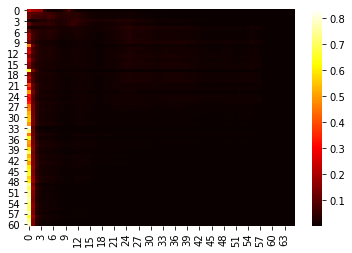

Train time: 1.05925395488739 min
TARGET: ['who...', 'even the second hour hands of the clock.', '- seriously - what is up with you', 'distant voice taki.', "it's actually splittin' apart", 'phone the number you are trying to reach is currently outside the cellular network or has been turned off due-', "and you can't contact her what's that about", "takagi gotch'a covered"]
PREDICTED: ['ihat', 'i can    e  ou  e  e  e  e  e  e  e  e  e  e  e  e  e  e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  ou  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e e  e ', '

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


TARGET: ["i- i'm sorry.", 'i did', "that's what you have a problem with", 'i was kind-of obsessed.', 'oh.', "'cause i'm on my way to you", "taki by the time the date's over", "residents in the followin' areas please evacuate to itomori high school immediately."]
PREDICTED: ['ihe  is  ou the  ou  ou ', 'ihat <sos>a  a e  ou  ou <sos><sos> <sos>e', 'i wa   ou  ou  ou  ou  ou  ou  ou  ou  ou  ou ', 'i  a s  ou the  ou  ou  ou  ou ', 'ihat', "it's  ou  ou  ou  ou  ou  ou  ou  ou the  ou the  ou the ", 'i what a  ou  ou  ou  ou  ou  ou ', '- the  a    ou  ou  ou                       ou  ou  ou  ou  ou  ou  ou  ou  ou  ou the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to e the  an  to

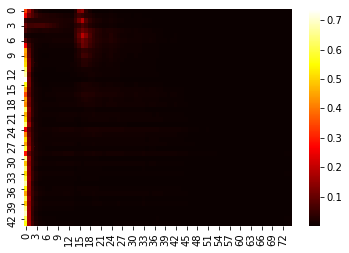

Train time: 1.0741188963254293 min
Distance:  146.0857142857143
Val time: 0.3862645427385966 min
Epoch 22...
Train_loss:  2.867283129590866


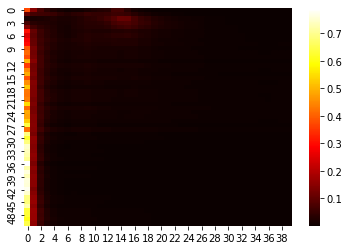

Train time: 1.0399096846580504 min
Distance:  231.14285714285714
Val time: 0.3754404147466024 min
Epoch 23...
Train_loss:  2.8595592884140277


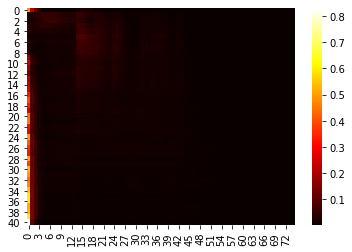

Train time: 1.0365272204081217 min
Distance:  54.02857142857143
Val time: 0.37731480995814004 min
Epoch 24...
Train_loss:  2.855475326365777


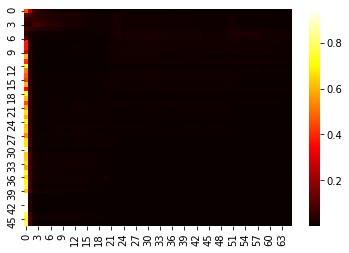

Train time: 1.036806881427765 min
Distance:  51.82857142857143
Val time: 0.3815163493156433 min
Epoch 25...
Train_loss:  2.8642070493937126


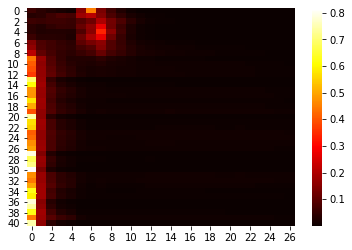

Train time: 1.0261693557103475 min
TARGET: ['- wanna hit the caf later - oh that one sure.', 'things to watch out for during the switches and a list of stuff we should never do.', "-i'll see you guys at the festival ba-bye -we'll meet ya at the step stone shrine. don't be late k", 'oh...', '- magic hour. - magic hour.', 'the landscapes people live in-', "yeah. i kinda feel like maybe i've been barking up the wrong tree this whole time.", 'the sorrowful gust of wind that blew right between you and me']
PREDICTED: ['- what a   a   o  o  o  o  o  ou  ou  ou  ou  ou the  ou the  ou.', '- what a                                                           a   o  the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou the  ou t

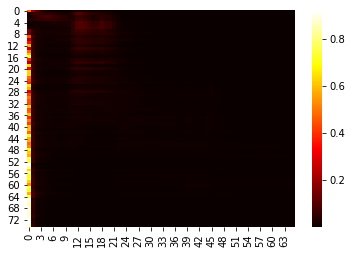

Train time: 1.047376024723053 min
Distance:  255.17142857142858
Val time: 0.3833700895309448 min
Epoch 27...
Train_loss:  2.827005252901231


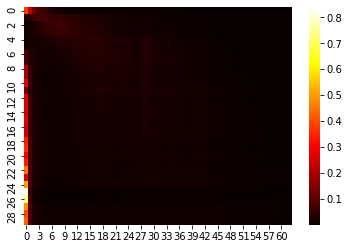

Train time: 1.0562294602394104 min
Distance:  25.4
Val time: 0.39639636675516765 min
Epoch 28...
Train_loss:  2.832761441493049


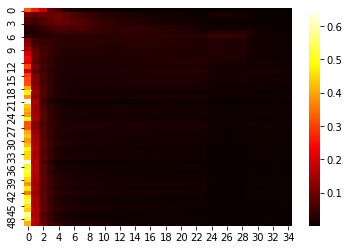

Train time: 1.0608887712160746 min
Distance:  158.68571428571428
Val time: 0.3815545876820882 min
Epoch 29...
Train_loss:  2.8227291840574487


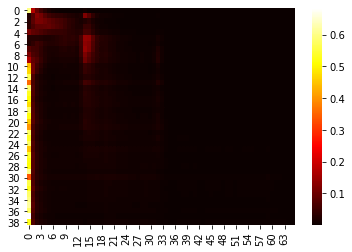

Train time: 1.0736781279246013 min
Distance:  92.57142857142857
Val time: 0.38371297121047976 min
Epoch 30...
Train_loss:  2.835642302953384


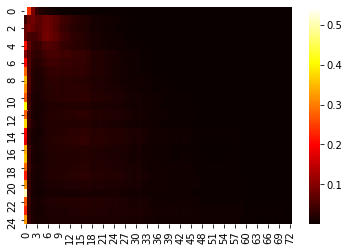

Train time: 1.0494389931360881 min
TARGET: ['-what what what', 'break', 'uh...', 'well believe it or not you forgot where your own desk and locker were yesterday.', "okudera is this place really where she's from", 'ding', 'good morning', 'your name...']
PREDICTED: ['- h a  and the  our  our  our ...', 'wha', '-hah', '- what a   an                                                            the  on  ou  on  our  our  our  our  our  our  our .', '- st s s at   the  o  the  ou  the  our  our .', '-hah', '- h    ou   ou  our  our ..', '-hah']
TARGET: ["let's make a promise that will never fade.", "you shouldn't go", "- you have a boyfriend in tokyo - i-i didn't say it was a date for me.", 'taki', '-you should be able to see the comet in the sky. -...you should be able to see the comet in the sky.', 'tired of playing hide-and-seek with time and', 'is mitsuha.', 'wha right now']
PREDICTED: ['what a   the  oo  o  the  our  our  our ', '- st a  it  hat ...', '- what a   an  o                   

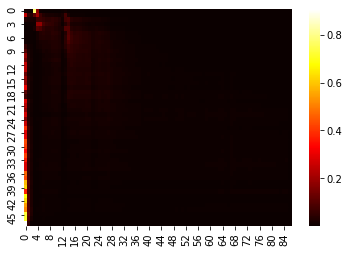

Train time: 1.0431286533673605 min
Distance:  78.48571428571428
Val time: 0.3836309870084127 min
Epoch 32...
Train_loss:  2.825432763853639


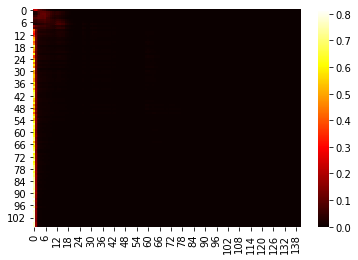

Train time: 1.051647953192393 min
Distance:  67.97142857142858
Val time: 0.38189709186553955 min
Epoch 33...
Train_loss:  2.809999179533339


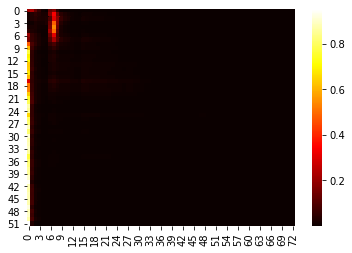

Train time: 1.0533013939857483 min
Distance:  42.42857142857143
Val time: 0.382791002591451 min
Epoch 34...
Train_loss:  2.811648932945205


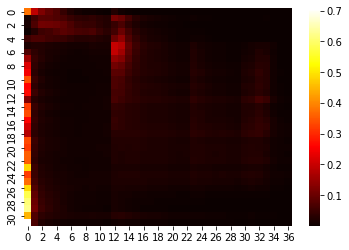

Train time: 1.0451216181119283 min
Distance:  55.542857142857144
Val time: 0.38422323067982994 min
Epoch 35...
Train_loss:  2.8036049338033138


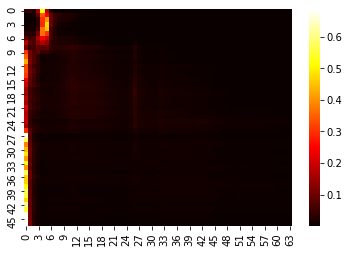

Train time: 1.0472607294718423 min
TARGET: ['taki.', 'what you did huh', '- went to tokyo - hey mitsuha', 'or...', "i'm in tokyo", 'thanks to my feminine powers', "- we're gonna need two or three more bottles. - yes dear.", 'gasp']
PREDICTED: ['- what a                  e  here.', '- what i                                                   o  the  o  the  o  the  on.', '- the                                                                       the  o  the  o  the  o  the  o  the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o the  o t', 'wha....', '- what a     

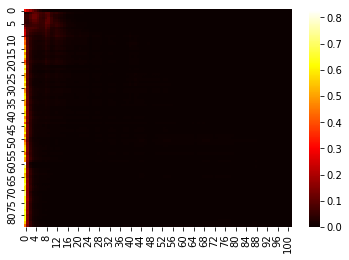

Train time: 1.0517633080482482 min
Distance:  175.34285714285716
Val time: 0.3874522487322489 min
Epoch 37...
Train_loss:  2.784659812496301


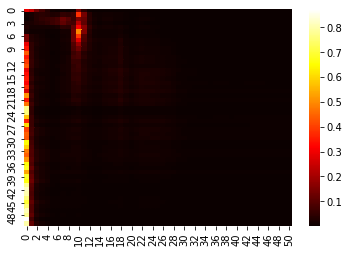

Train time: 1.0715759793917339 min
Distance:  59.51428571428571
Val time: 0.3806463162104289 min
Epoch 38...
Train_loss:  2.7960847033556755


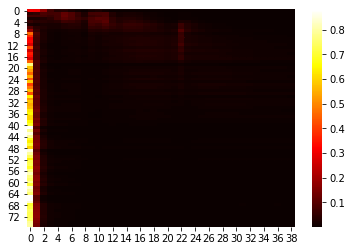

Train time: 1.0554683883984883 min
Distance:  85.02857142857142
Val time: 0.3867972373962402 min
Epoch 39...
Train_loss:  2.781174351843123


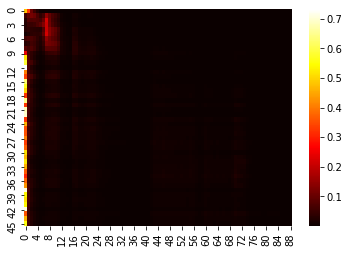

Train time: 1.0608797113100688 min
Distance:  67.8
Val time: 0.3797533472379049 min
Epoch 40...
Train_loss:  2.800893006352402


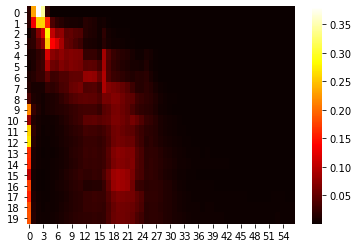

Train time: 1.0404205997784932 min
TARGET: ["wow it's already magic hour", "- you have a boyfriend in tokyo - i-i didn't say it was a date for me.", "forgotten now are rollin' 'round the corners of the floor.", 'you know what', 'the comet is going to fall on itomori', '-what what what', 'thanks but i gotta go to work.', 'met you somewhere']
PREDICTED: ['- th t  he  ou  ou  ou  ou  ou  ou  ou  ou  ou  out', '- th ha  o  the  o  the  ou  ou  ou  ou  ou  ou  ou  ou the  out the  out the  out the  out ', '- th he  o  the  o  the  o  the  o  the  ou  ou  ou  ou  the  ou the  out the  out the  out the  out the  out the  out the  out the  out the  out the  out the  out the  out the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  and the  

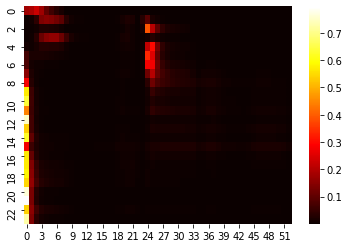

Train time: 1.0502858877182006 min
Distance:  155.5142857142857
Val time: 0.3775222023328145 min
Epoch 42...
Train_loss:  2.7738048105241164


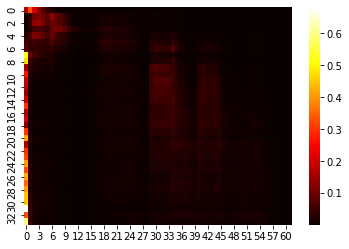

Train time: 1.0494123061498006 min
Distance:  79.11428571428571
Val time: 0.3867124994595846 min
Epoch 43...
Train_loss:  2.7600951770453936


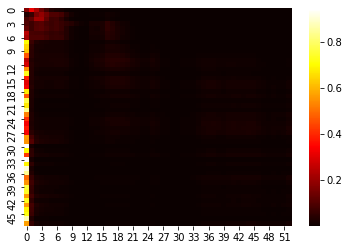

Train time: 1.0527987798055014 min
Distance:  118.71428571428571
Val time: 0.3842382947603861 min
Epoch 44...
Train_loss:  2.7544006621520527


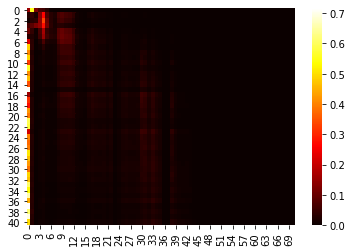

Train time: 1.0495322108268739 min
Distance:  44.17142857142857
Val time: 0.3860721230506897 min
Epoch 45...
Train_loss:  2.778856935394231


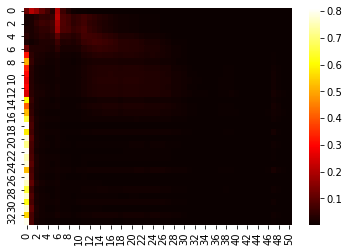

Train time: 1.0410760521888733 min
TARGET: ['only the surface was left.', "- hey that's rude - y'know i gotta say. you two make a great couple.", '- so what did you guys do - so what did you guys do - so what did you guys do', 'well thanks for today. see you at work', "i've always been insisting there was something that i've longing for.", 'did i even come here for', 'taki.', 'over the course of the last few days the tiamat comet has been visible but when and where can people see it']
PREDICTED: ['- what s s it   s  the   so  the  a e the ', '- the   a   the  o                                             a   a   a  a e the  a e the ', 'toe so  the   to t  t e sour ', '- what                                            the   a   the  a  a  a the  a the  a the ', 'taki i  e e the  i   it  it  it there', 'i what s  to      the   to    to   the   a the  a e the ', '- ah  a   a   a   a   a   a   are.', '- what                                                                        the  a   th

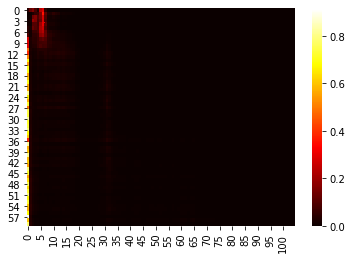

Train time: 1.0392948389053345 min
Distance:  67.48571428571428
Val time: 0.377597181002299 min
Epoch 47...
Train_loss:  2.726146479696875


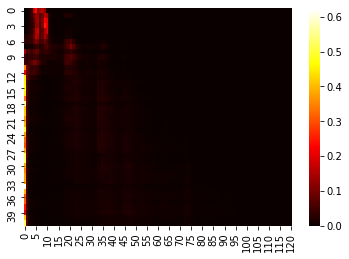

Train time: 1.0386684616406758 min
Distance:  50.57142857142857
Val time: 0.356278657913208 min
Epoch 48...
Train_loss:  2.729916661865458


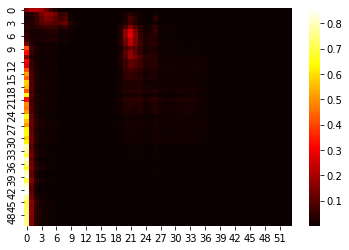

Train time: 1.0241609454154967 min
Distance:  52.8
Val time: 0.357418421904246 min
Epoch 49...
Train_loss:  2.723881365750582


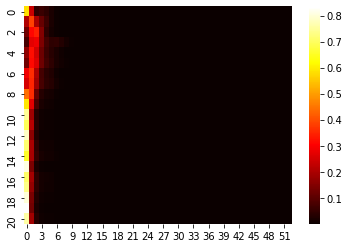

Train time: 1.0179922461509705 min
Distance:  62.25714285714286
Val time: 0.35693196058273313 min


In [181]:
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction='none').to(device)
mode = 'train'

for epoch in range(num_epochs):
  print(f"Epoch {epoch}...")
  start_time = time.time()
  
  att = train(model, train_loader, criterion, optimizer, mode)
  plot_attention(att)
  
  train_time = time.time()
  print(f"Train time: {(train_time - start_time)/60} min")

  val(model, valid_loader, epoch)
  
  val_time = time.time()
  print(f"Val time: {(val_time - train_time)/60} min")